## Epoch 4 -- Quicklook photometry, astrometry, and SNR

In [1]:
import numpy as np
import scipy.ndimage
import skimage.transform
import skimage.registration
import os
import pandas
import csv

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.cmap'] = 'inferno'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.origin'] = 'lower'
plt.style.use('dark_background')

import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
import astropy.table
import photutils

import scipy.signal

### File paths

In [2]:
analysis_results_dir = os.path.relpath("./results/")
cal_data_dir = os.path.relpath("../../Data/official2019/HLC/HLC CAL/")

rdi_coadd_fname = os.path.join(analysis_results_dir, "HLC_scistar_RDI_rollcomb_seq.fits")
psf_model_fname = os.path.join(analysis_results_dir, 'hlc_centered_psf.fits')

star_cal_fname = os.path.join(cal_data_dir, "HLC_scistar_unocc_PSF_model.fits")
psf_peak_map_fname = os.path.join(cal_data_dir, 'OS6_HLC_PSF_peak_map.fits')

In [3]:
os.listdir(cal_data_dir)

['OS6_HLC_PSFs_offset.fits',
 'OS6_HLC_PSFs_fine_offset_list.fits',
 'unocc_star_psf.png',
 'OS6_HLC_PSFs_fine_offset.fits',
 'OS6_HLC_PSF_peak_map.fits',
 'HLC_scistar_unocc_PSF_model.fits',
 'OS6_HLC_PSFs_offset_list.fits',
 'hlc_psf_peak_map.png']

### Misc. observation and data parameters

In [4]:
epoch_ind = 3

det_qe = 0.75 * u.electron / u.photon # effective QE of detector
pc_loss = 0.8 # photon counting coincidence losses
tot_inttime = 2 * 66000 * u.second
print(tot_inttime.to(u.hour))

36.666666666666664 h


In [5]:
hdr = fits.getheader(rdi_coadd_fname)
pix_scale = (hdr['PIX_AS'] * u.arcsecond).to(u.mas)
rdi_coadd_cube = fits.getdata(rdi_coadd_fname)
rdi_coadd_cube.shape

(4, 45, 45)

In [6]:
psf_peak_map = fits.getdata(psf_peak_map_fname)
psf_peak_map_hdr = fits.getheader(psf_peak_map_fname)
pixscale_ratio = hdr['PIX_LD'] / psf_peak_map_hdr['PIXSIZE']
print(pixscale_ratio)

4.2000023908478346


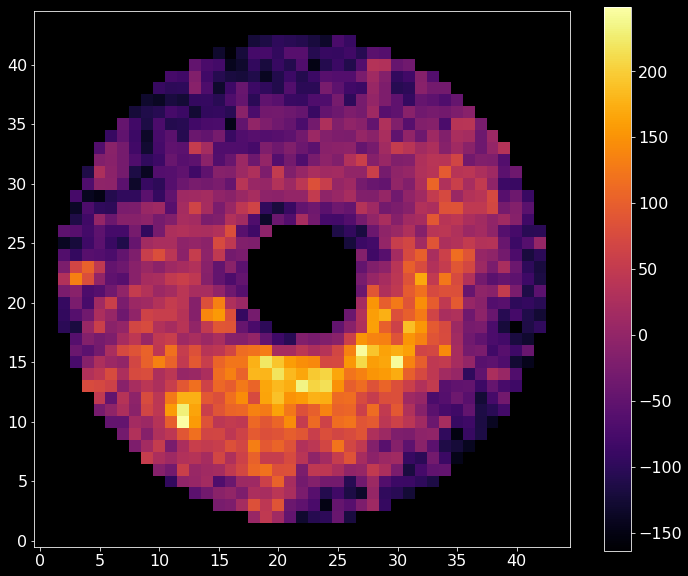

In [7]:
plt.figure(figsize=(12,10))

plt.imshow(rdi_coadd_cube[epoch_ind])

plt.colorbar()

Peak col = 12, peak row = 10
Source angular separation 15.62 pixels, 329.29 mas
Peak value = 248.8
Sum in 3 x 3 box = 1310.02 electron


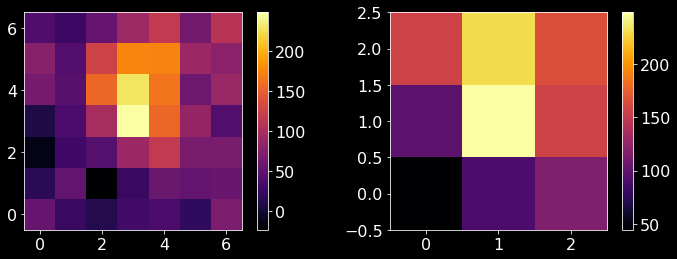

In [8]:
rdi_coadd_img = rdi_coadd_cube[epoch_ind]
img_width = rdi_coadd_img.shape[0]
phot_box_width = 3

peak_row = np.nanargmax(np.ravel(rdi_coadd_img)) // img_width
#peak_row = 11
peak_col = np.nanargmax(np.ravel(rdi_coadd_img)) % img_width
peak_val = rdi_coadd_img[peak_row, peak_col]
src_sep_pix = np.sqrt((peak_col - img_width // 2)**2 + (peak_row - img_width // 2)**2)
src_sep_mas = src_sep_pix * pix_scale

phot_box_sum = np.sum(rdi_coadd_img[peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
                                    peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1]) * u.electron

print("Peak col = {:d}, peak row = {:d}".format(peak_col, peak_row))
print("Source angular separation {:.2f} pixels, {:.2f}".format(src_sep_pix, src_sep_mas))
print("Peak value = {:.1f}".format(peak_val))
print("Sum in {:d} x {:d} box = {:.2f}".format(phot_box_width, phot_box_width, phot_box_sum))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_box_width = 7
plt.imshow(rdi_coadd_img[peak_row - plot_box_width//2 : peak_row + plot_box_width // 2 + 1,
                         peak_col - plot_box_width//2 : peak_col + plot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(122)
plt.imshow(rdi_coadd_img[peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
                         peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1])
plt.colorbar()

B.g. estimate = 55.949 electron
B.g. std dev = 34.206 electron
B.g.-subtracted aperture sum = 806.478 electron
Peak-to-B.g. SNR estimate = 5.6


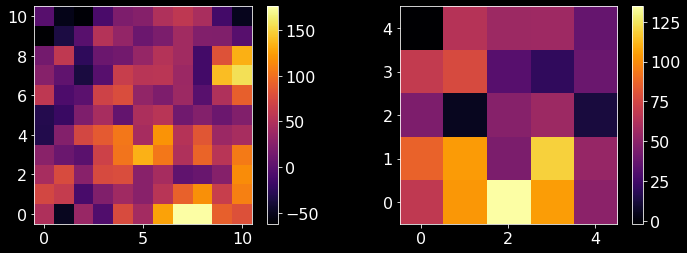

In [9]:
bg_samp_col = 10
bg_samp_row = 17
bg_box_width = 5
bg_est = np.median(rdi_coadd_img[bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                                 bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1]) * u.electron

bg_std = np.std(rdi_coadd_img[bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                              bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1]) * u.electron

peak_to_bg_SNR = (peak_val * u.electron - bg_est) / bg_std

phot_box_sum_bgsub = phot_box_sum - bg_est * (phot_box_width * phot_box_width)

print("B.g. estimate = {:.3f}".format(bg_est))
print("B.g. std dev = {:.3f}".format(bg_std))
print("B.g.-subtracted aperture sum = {:.3f}".format(phot_box_sum_bgsub))
print("Peak-to-B.g. SNR estimate = {:.1f}".format(peak_to_bg_SNR))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_box_width = 10
plt.imshow(rdi_coadd_img[bg_samp_row - plot_box_width//2 : bg_samp_row + plot_box_width // 2 + 1,
                         bg_samp_col - plot_box_width//2 : bg_samp_col + plot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(122)
plt.imshow(rdi_coadd_img[bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                         bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1])
plt.colorbar()

In [10]:
peak_map_width = psf_peak_map.shape[0]

src_peak_map_col = (peak_map_width // 2 
                    + int(np.round((peak_col - img_width // 2)
                    * pixscale_ratio)))
src_peak_map_row = (peak_map_width // 2
                    + int(np.round((peak_row - img_width // 2)
                    * pixscale_ratio)))

print("Source position in peak map: {:}, {:}".format(src_peak_map_col, src_peak_map_row))

psf_atten = psf_peak_map[src_peak_map_row, src_peak_map_col] / np.max(psf_peak_map)
print("Relative PSF attenuation: {:.2f}".format(psf_atten))

Source position in peak map: 58, 50
Relative PSF attenuation: 0.99


25 25
Peak col = 25, peak row = 25
Star count rate in 3 x 3 box = 5955766.26 ph / s


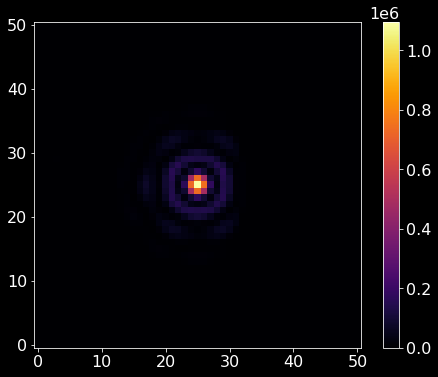

In [11]:
star_cal_img = fits.getdata(star_cal_fname)
star_cal_img_width = star_cal_img.shape[0]

star_peak_row = np.nanargmax(np.ravel(star_cal_img)) // star_cal_img_width
star_peak_col = np.nanargmax(np.ravel(star_cal_img)) % star_cal_img_width
print(star_peak_col, star_peak_row)

star_phot_box_sum = (np.sum(star_cal_img[star_peak_row - phot_box_width//2 : star_peak_row + phot_box_width // 2 + 1,
                                         star_peak_col - phot_box_width//2 : star_peak_col + phot_box_width // 2 + 1])
                     * u.photon / u.second)

print("Peak col = {:d}, peak row = {:d}".format(star_peak_col, star_peak_row))
print("Star count rate in {:d} x {:d} box = {:.2f}".format(phot_box_width, phot_box_width, star_phot_box_sum))

plt.figure(figsize=(8, 6))
plt.imshow(star_cal_img)
plt.colorbar()

In [12]:
planet_phot_box_sum = (phot_box_sum_bgsub / (det_qe * pc_loss * psf_atten)) / tot_inttime
print("Planet PSF photon count rate in {:d} x {:d} box = {:.2E}".format(
      phot_box_width, phot_box_width, planet_phot_box_sum))

planet_flux_ratio = planet_phot_box_sum / star_phot_box_sum
print("Measured planet flux ratio = {:.3E}".format(planet_flux_ratio))

Planet PSF photon count rate in 3 x 3 box = 1.03E-02 ph / s
Measured planet flux ratio = 1.724E-09


## Photutils centroid and photometry 

In [13]:
cut_width = 11
src_cutout = rdi_coadd_img[peak_row - cut_width//2 : peak_row + cut_width // 2 + 1,
                           peak_col - cut_width//2 : peak_col + cut_width // 2 + 1]


bg_box = rdi_coadd_img[bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                       bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1]

bg_std = np.std(bg_box)
print(bg_std)

34.20630189084178


In [14]:
np.nanstd(rdi_coadd_img)

76.73763301209308

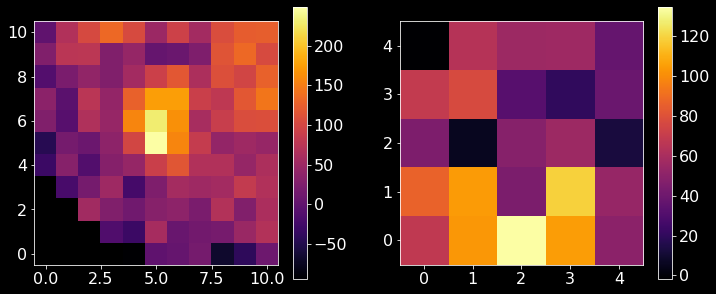

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(src_cutout)
plt.colorbar()
plt.subplot(122)
plt.imshow(bg_box)
plt.colorbar()

In [16]:
result = photutils.centroids.fit_2dgaussian(data = src_cutout,
                                            error = np.ones_like(src_cutout) * bg_std)

In [17]:
result

<GaussianConst2D(constant=-1204.02883388, amplitude=1316.00813346, x_mean=7.62744969, y_mean=7.33518288, x_stddev=16.79521848, y_stddev=20.06750903, theta=-36.39905719)>

In [18]:
psf_model = fits.getdata(psf_model_fname)
psf_model_shift = scipy.ndimage.shift(psf_model, [0.5, 0.5])
psf_model_crop = 11
psf_model_crop = psf_model_shift[psf_model.shape[0] // 2 - psf_model_crop//2:psf_model.shape[0] // 2 + psf_model_crop//2 + 1,
                                 psf_model.shape[0] // 2 - psf_model_crop//2:psf_model.shape[0] // 2 + psf_model_crop//2 + 1]

In [19]:
psf_model_crop.shape

(11, 11)

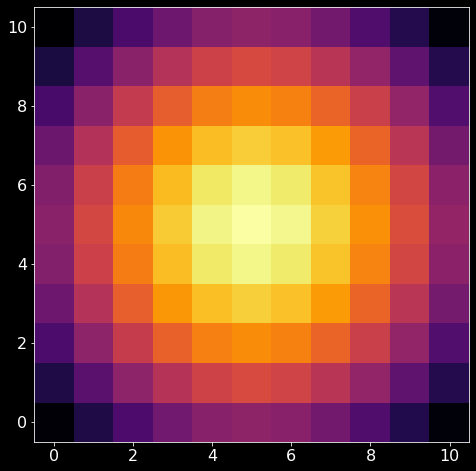

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(psf_model_crop[:,:])

In [21]:
hdr['PIX_AS']

0.0210804

In [22]:
hdr['PIX_LD']

0.4200002390847835

In [23]:
scale_fac = hdr['PIX_LD'] / 0.1
src_cutout_rescaled = skimage.transform.rescale(src_cutout, scale = scale_fac)
src_cutout_rescaled.shape

(46, 46)

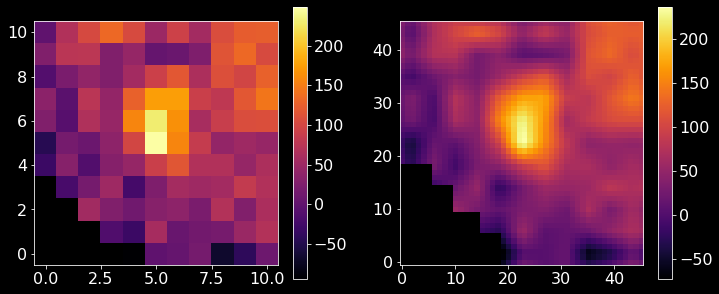

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(src_cutout)
plt.colorbar()
plt.subplot(122)
plt.imshow(src_cutout_rescaled)
plt.colorbar()

In [25]:
#src_crop = src_cutout_rescaled.shape[0] - psf_model_crop.shape[0]
src_cutout_rescaled_cropped = src_cutout_rescaled[
        src_cutout_rescaled.shape[0] // 2 - psf_model_crop.shape[0] // 2:src_cutout_rescaled.shape[0] // 2 + psf_model_crop.shape[0] // 2 + 1,
        src_cutout_rescaled.shape[0] // 2 - psf_model_crop.shape[0] // 2:src_cutout_rescaled.shape[0] // 2 + psf_model_crop.shape[0] // 2 + 1]

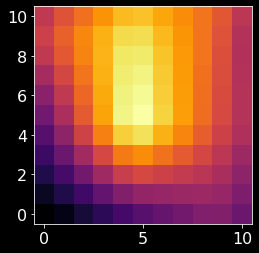

In [26]:
plt.figure()
plt.imshow(src_cutout_rescaled_cropped)

In [27]:
src_cutout_rescaled_cropped.shape

(11, 11)

In [28]:
cross_corr_result = skimage.registration.phase_cross_correlation(reference_image = psf_model_crop,
                                                                 moving_image = src_cutout_rescaled_cropped,
                                                                 upsample_factor = 10)

In [29]:
cross_corr_result

(array([-1.5, -0.3]), 0.13365996883998527, -2.10410207059663e-18)

In [30]:
src_y = peak_row - cross_corr_result[0][0] / scale_fac
src_x = peak_col - cross_corr_result[0][1] / scale_fac

In [31]:
peak_row, peak_col

(10, 12)

In [32]:
src_y, src_x

(10.357142653839585, 12.071428530767918)

In [33]:
src_y_offset = (src_y - img_width // 2) * pix_scale
src_x_offset = (src_x - img_width // 2) * pix_scale

In [34]:
src_y_offset.to(u.mas), src_x_offset.to(u.mas)

(<Quantity -245.43609 mas>, <Quantity -209.298258 mas>)

In [35]:
sigma = (1 / hdr['PIX_LD']) / peak_to_bg_SNR * pix_scale

In [36]:
sigma

<Quantity 8.90237501 mas>